# Exploration detection in mice videos

In this notebook, we implement two methods to find exploration events in mice videos computationally:

- A custom algorithm which uses the tracked position data for the mouse to determine its orientation and proximity to each object.

- A machine learning model (random forest).

One of our videos will be set aside for comparison purposes; we will apply our custom algorithm to this video. Then, we will train the machine learning algorithm on the other videos and use the resulting model to predict exploration on the test video. These results will be compared to those of the custom algorithm and to the manual labels.

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import os

from utils import Point, Obj, Vector

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Getting our file names

First, we get a list of all the tracked and labeled files in our data directory.

In [37]:
# Path to data directory
path = 'DataDLC/videos_eval/'

# Names of files in the data directory
file_names = os.listdir(path)

# Names of files with tracked positions or labels
position_files = []
label_files = []

for file_name in file_names:
    if "Position.h5" in file_name:
        position_files.append(file_name)
    elif "Labels.csv" in file_name:
        label_files.append(file_name)

Then, we separate the files corresponding to one of the videos.

In [38]:
video = 18
p_test = position_files.pop(video - 1)
l_test = label_files.pop(video - 1)

## Custom algorithm


We start by importing the tracked positions and the labels for the test video.

In [39]:
# Positions tracked using DLC
tracked_data = pd.read_hdf(path + p_test)['DLC_resnet50_brainhackMay25shuffle1_230000']
print(tracked_data.head())

# Labels (applied used Label_videos.py)
labels = pd.read_csv(path + l_test)
print(labels.head())

bodyparts       obj_1                              obj_2               
coords              x           y likelihood           x           y   
0          209.421158  152.337585   0.999912  493.363037  151.453583  \
1          209.244492  152.201462   0.999918  493.515320  151.463531   
2          209.199936  152.266144   0.999918  493.454346  151.648788   
3          209.293472  152.215744   0.999928  493.421692  151.511017   
4          209.136658  152.332520   0.999920  493.520691  151.726440   

bodyparts                   nose                              L_ear  ...   
coords    likelihood           x           y likelihood           x  ...   
0           0.999899  202.733536  179.412918   0.001977  478.886292  ...  \
1           0.999906  202.892059  179.436508   0.001660  478.897339  ...   
2           0.999884  202.750305  179.556442   0.001860  478.977264  ...   
3           0.999894  202.825500  179.652985   0.001760  478.819000  ...   
4           0.999887  202.935318  179.6

We extract the positions of both objects and plot them to check they remain constant throughout the video (as they should).

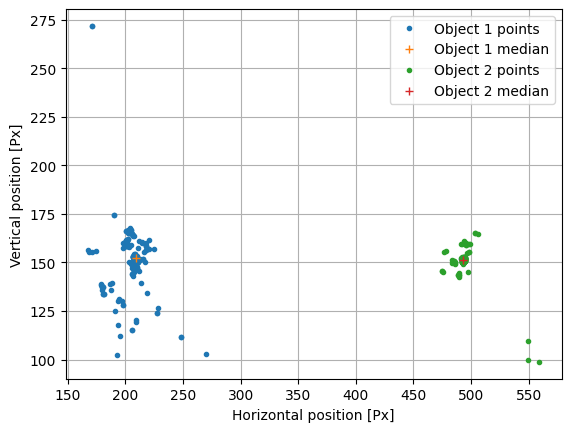

In [40]:
# Extract positions of both objects
obj1 = Obj(tracked_data, 'obj_1')
obj2 = Obj(tracked_data, 'obj_2')

# Plot positions of both objects and their medians
plt.plot(*obj1.positions.T, ".", label = "Object 1 points")
plt.plot(*obj1.median_coordinates, "+", label = "Object 1 median")

plt.plot(*obj2.positions.T, ".", label = "Object 2 points")
plt.plot(*obj2.median_coordinates, "+", label = "Object 2 median")

plt.xlabel("Horizontal position [Px]")
plt.ylabel("Vertical position [Px]")
plt.grid()
plt.legend()

Since the positions of the objects remain mostly constant around their medians, we can replace their coordinates in every frame by their median coordinates (given by `Obj().median_array`).

In [41]:
obj1.positions = obj1.median_array
obj2.positions = obj2.median_array

We can now apply a **custom algorithm** to classify each frame.

Intuitively, it makes sense to consider not only the proximity of the mouse to the object, but also its orientation (that is, whether the mouse is looking at the object). This means we need to consider at least two points on the mouse: we will use its nose and its head.

We will classify as explorations those points which satisfy two conditions:

- The nose is close to the center of a given object (within a certain `maxDistance`).

- The angle between the head-nose vector and the head-object vector is smaller than a certain `maxAngle`.

We begin by extracting the positions of the head and nose of the mouse, and plotting their values for some frames.

In [42]:
# Extract nose positions
nose = Point(tracked_data, 'nose')

# Extract head positions
head = Point(tracked_data, 'head')

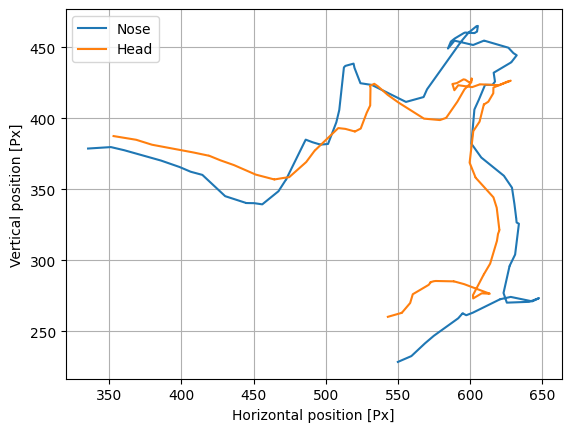

In [43]:
# Plot some points
plt.plot(*nose.positions[1000:1100].T, label="Nose")
plt.plot(*head.positions[1000:1100].T, label="Head")

plt.xlabel("Horizontal position [Px]")
plt.ylabel("Vertical position [Px]")
plt.grid()
plt.legend()

We now filter the frames where the mouse's nose is close to each object.

In [44]:
# Find distance from the nose to each object
dist1 = Point.dist(nose, obj1)
dist2 = Point.dist(nose, obj2)

# Find points where the nose is close to obj1
maxDistance = 60 # pixels (4 cm)
close1 = nose.positions[dist1 < maxDistance]

# Find points where the nose is close to obj2
close2 = nose.positions[dist2 < maxDistance]

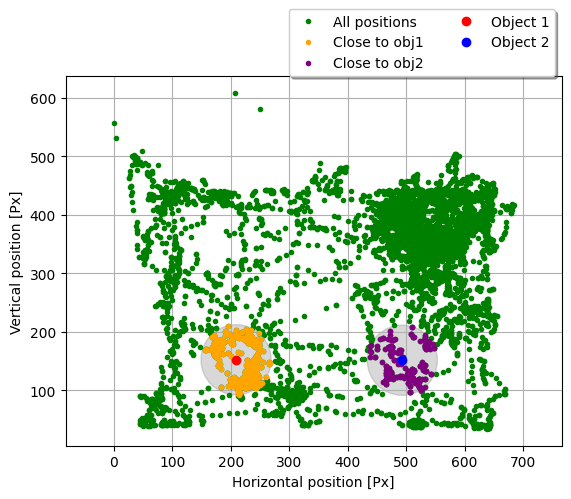

In [45]:
# Plot points, objects and distance around the center of each object
# Highlight positions where the mouse is close to each object
fig, ax = plt.subplots()

ax.plot(*nose.positions.T, ".", label = "All positions", color = "green")

ax.plot(*close1.T, ".", label = "Close to obj1", color = "orange")
ax.plot(*close2.T, ".", label = "Close to obj2", color = "purple")

ax.plot(*obj1.median_coordinates, "o", lw = 20, label = "Object 1", color = "red")
ax.plot(*obj2.median_coordinates, "o", lw = 20, label = "Object 2", color = "blue")

ax.add_artist(Circle(obj1.median_coordinates, maxDistance, color = "grey", alpha = 0.3))
ax.add_artist(Circle(obj2.median_coordinates, maxDistance, color = "grey", alpha = 0.3))

ax.axis('equal')
ax.grid()
ax.set_xlabel("Horizontal position [Px]")
ax.set_ylabel("Vertical position [Px]")
ax.legend(bbox_to_anchor = (0, 0.2, 1, 1), ncol=2, fancybox=True, shadow=True)

Next, we filter the points where the mouse is looking at each object and plot them.

In [46]:
# Compute normalized head-nose and head-object vectors
head_nose = Vector(head, nose, normalize=True)
head_obj1 = Vector(head, obj1, normalize=True)
head_obj2 = Vector(head, obj2, normalize=True)

# Find the angles between the head-nose and head-object vectors
angle1 = Vector.angle(head_nose, head_obj1) # deg
angle2 = Vector.angle(head_nose, head_obj2) # deg

# Find points where the mouse is looking at obj1
maxAngle = 50 # deg
towards1 = nose.positions[angle1 < 50]

# Find points where the mouse is looking at obj2
towards2 = nose.positions[angle2 < 50]

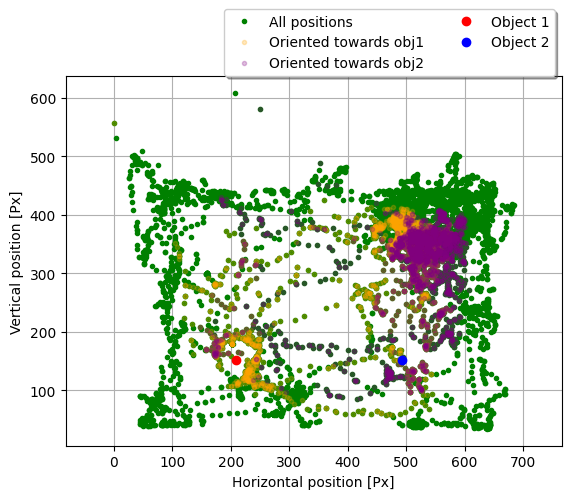

In [47]:
# Plot points and objects, highlighting positions where the mouse is looking at each object
fig, ax = plt.subplots()

ax.plot(*nose.positions.T, ".", label = "All positions", color = "green")

ax.plot(*towards1.T, ".", label = "Oriented towards obj1", color = "orange", alpha=0.25)
ax.plot(*towards2.T, ".", label = "Oriented towards obj2", color = "purple", alpha=0.25)

ax.plot(*obj1.median_coordinates, "o", lw = 20, label = "Object 1", color = "red")
ax.plot(*obj2.median_coordinates, "o", lw = 20, label = "Object 2", color = "blue")

ax.axis('equal')
ax.grid()
ax.set_xlabel("Horizontal position [Px]")
ax.set_ylabel("Vertical position [Px]")
ax.legend(bbox_to_anchor = (0, 0.2, 1, 1), ncol=2, fancybox=True, shadow=True)

Up until now we've considered the distance and orientation conditions separately: let's put them together to label each frame in the video. We'll label each frame with a $+1$ if the mouse is exploring object 1, $-1$ if it's exploring object 2 and $0$ if it's not exploring any object.

In [49]:
frameCount = len(dist1)

geometric_labels = np.zeros(frameCount)

for i in range(frameCount):
    # Check if mouse is exploring object 1
    if dist1[i] < maxDistance and angle1[i] < maxAngle:
        geometric_labels[i] = 1
    
    # Check if mouse is exploring object 2
    elif dist2[i] < maxDistance and angle2[i] < maxAngle:
        geometric_labels[i] = -1        

That's it for our custom algorithm. We'll now train a Random Forest model on the other videos.

## Random Forest model

As we have already mentioned, the Machine Learning model will be trained on all but one of our videos: the remaining one (the one on which we have also run our custom algorithm) will be used to evaluate the model and compare the different detection methods.

We start by preparing the data corresponding to all the training videos and that of the testing video. We have chosen to use as features the $(x, y)$ positions of both objects and of all the parts of the mouse that we tracked using DLC: nose, head, neck, body, both ears and three points on the tail.

In [50]:
# DataFrame to store all the features and labels for the training videos
data = pd.DataFrame(columns = ['obj_1_x', 'obj_1_y', 'obj_2_x', 'obj_2_y', 'nose_x', 'nose_y', 'L_ear_x', 'L_ear_y', 'R_ear_x', 'R_ear_y', 'head_x', 'head_y', 'neck_x', 'neck_y', 'body_x', 'body_y', 'tail_1_x', 'tail_1_y', 'tail_2_x', 'tail_2_y', 'tail_3_x', 'tail_3_y', 'label'])

# Loop over the tracked data and labels for each video
for i in range(len(position_files)):
    
    tracked_file = path + position_files[i]
    labels_file = path + label_files[i]

    tracked_df = pd.read_hdf(tracked_file)['DLC_resnet50_brainhackMay25shuffle1_230000']
    labels = pd.read_csv(labels_file)
    
    # DataFrame storing features and labels for the current file
    current_data = pd.DataFrame()
    
    for key in tracked_df.keys():
        if key[1] != "likelihood":
            # Replace the positions of the objects in every frame by their medians across the video
            if key[0] == "obj_1" or key[0] == "obj_2":
                current_data[str(key[0]) + "_" + str(key[1])] = [tracked_df[key].median()] * len(tracked_df[key])
            else:
                current_data[str( key[0] ) + "_" + str( key[1] )] = tracked_df[key]
                
    # Set label to +1 if the mouse is looking at the object on the left, -1 if it's looking at the object on the right
    current_data["label"] = labels["Left"] - labels["Right"]

    data = pd.concat([data, current_data], ignore_index = True)

data.head()

,obj_1_x,obj_1_y,obj_2_x,obj_2_y,nose_x,nose_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,...,neck_y,body_x,body_y,tail_1_x,tail_1_y,tail_2_x,tail_2_y,tail_3_x,tail_3_y,label
0,211.62339,126.879261,490.894608,130.541367,493.968903,145.419083,220.939026,139.538330,494.911072,141.679214,...,137.020813,217.076752,130.977478,221.013916,119.491524,200.888901,122.599762,468.354584,124.238983,0
1,211.62339,126.879261,490.894608,130.541367,493.997711,145.367249,220.925629,139.548492,494.908630,141.667130,...,137.082642,217.129929,131.070435,220.922226,119.515617,200.859634,122.559868,514.018982,119.581596,0
2,211.62339,126.879261,490.894608,130.541367,494.029572,145.378448,220.926605,139.548325,494.918854,141.679764,...,137.082733,217.130844,131.073593,220.923859,119.520943,200.858963,122.560883,468.297028,124.074997,0
3,211.62339,126.879261,490.894608,130.541367,494.092102,145.403580,220.928314,139.493881,494.897980,141.667450,...,137.131409,217.102051,131.051361,220.729248,119.474564,200.832581,122.488029,514.018555,119.597374,0
4,211.62339,126.879261,490.894608,130.541367,494.074280,145.399399,220.927490,139.501328,494.884552,141.657944,...,137.142166,217.102631,131.045410,220.734451,119.475830,200.823929,122.479134,514.004272,119.564201,0


In [51]:
# Let's now prepare the testing data
# DataFrame to store all the features and labels for the testing video
test = pd.DataFrame()

# Tracked positions
tracked_df = pd.read_hdf(path + p_test)['DLC_resnet50_brainhackMay25shuffle1_230000']

# Manual labels
labels = pd.read_csv(path + l_test)

for key in tracked_df.keys():
    if key[1] != "likelihood":
        if key[0] == "obj_1" or key[0] == "obj_2":
            test[str(key[0]) + "_" + str(key[1])] = [tracked_df[key].median()] * len(tracked_df[key])
        else:
            test[str(key[0]) + "_" + str(key[1])] = tracked_df[key]
    
test["label"] = labels["Left"] - labels["Right"]

test.head()

,obj_1_x,obj_1_y,obj_2_x,obj_2_y,nose_x,nose_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,...,neck_y,body_x,body_y,tail_1_x,tail_1_y,tail_2_x,tail_2_y,tail_3_x,tail_3_y,label
0,209.216331,152.156433,493.339523,151.297249,202.733536,179.412918,478.886292,157.321762,221.409683,157.107224,...,162.126114,217.516724,154.429977,202.583206,153.552948,202.242676,156.181442,203.625931,183.373291,0
1,209.216331,152.156433,493.339523,151.297249,202.892059,179.436508,478.897339,157.301697,221.503738,157.118683,...,146.544434,217.408295,154.455139,202.709061,153.452332,199.519348,135.828247,204.211426,157.042877,0
2,209.216331,152.156433,493.339523,151.297249,202.750305,179.556442,478.977264,157.467316,221.391342,157.148376,...,162.102921,217.377502,154.458359,202.728928,153.439575,199.536926,135.783371,203.662354,183.382385,0
3,209.216331,152.156433,493.339523,151.297249,202.825500,179.652985,478.819000,157.412323,221.441483,157.173630,...,146.358124,217.443970,154.435364,202.704529,153.470490,199.431519,135.812729,471.477631,137.501495,0
4,209.216331,152.156433,493.339523,151.297249,202.935318,179.675339,478.801483,157.479431,221.330399,157.168472,...,146.416809,217.350327,154.381119,202.756943,153.379211,199.441727,135.786911,204.289276,157.012207,0


Now, we separate the features and labels for our traning set, and train the Random Forest classifier.

In [32]:
# X contains our independent variables
X = data.drop(["label"], axis = 1)

# y contains our depend variable
y = data.label.astype('int')

# Create the Random Forest model (and set the number of estimators (decision trees))
BA_model = RandomForestClassifier(n_estimators = 60, random_state = 42, max_depth = 30, class_weight = "balanced")

# Train the model
BA_model.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=60,
                       random_state=42)

We can now use this model to predict the labels for our testing data.

In [52]:
BA_label = BA_model.predict(test.drop(["label"], axis = 1))

## Comparison between the three methods

Before we can compare the three methods, we need to extract the manual labels for the testing video.

In [54]:
manual_label = np.zeros(frameCount)

for frame in range(frameCount):
    if labels["Left"][frame] == 1:
        manual_label[frame] = 1
    elif labels["Right"][frame] == 1:
        manual_label[frame] = -1     
    else:
         manual_label[frame] = 0

### Time series extracted from test video

To start with, we will plot the time series corresponding to the testing video, indicating the predictions made by our custom algorithm and by the Machine Learning classifier, as well as the manual labels.

We will also plot the distance and angle from the mouse to each object, in order to relate their minima to the predictions made by our custom algorithm.

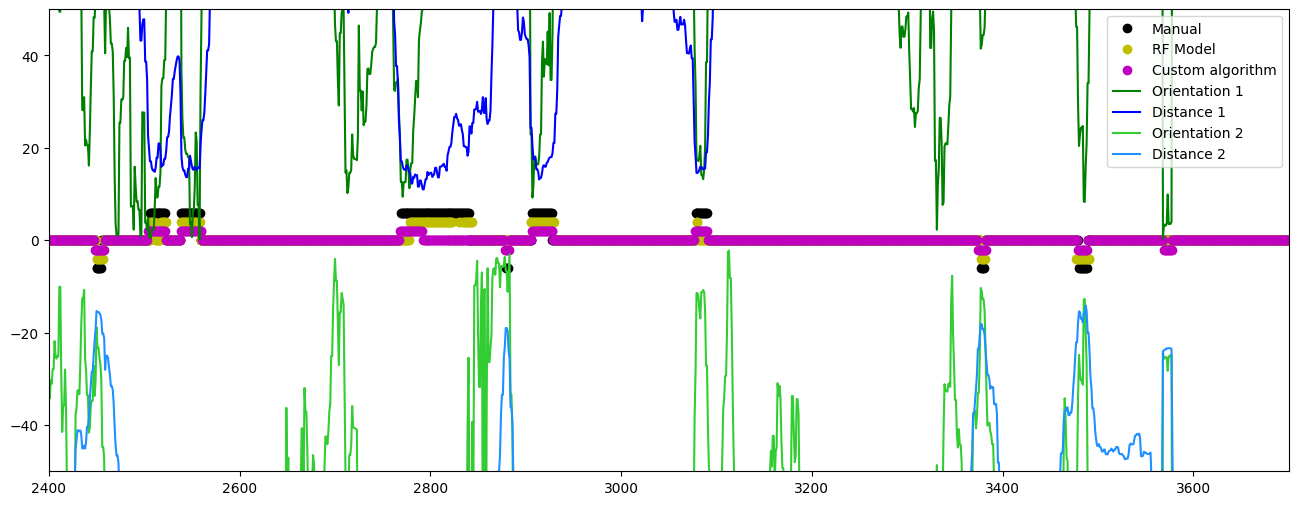

In [68]:
# Set start and finish frames
a, b = 0, -1

plt.figure(figsize = (16, 6))
plt.plot(manual_label[a:b] * 6, "o", color = "k", label = "Manual")
plt.plot(BA_label[a:b] * 4, "o", color = "y", label = "RF Model")
plt.plot(geometric_labels[a:b] * 2, "o", color = "m", label = "Custom algorithm")
plt.plot(angle1[a:b], color = "g", label = "Orientation 1")
plt.plot(dist1[a:b] / 2.5, color = "b", label = "Distance 1" )
plt.plot(angle2[a:b] * (-1), color = "limegreen", label = "Orientation 2")
plt.plot(dist2[a:b] / 2.5 * (-1), color = "dodgerblue", label = "Distance 2")

# Zoom in on some frames
plt.xlim((2400, 3700))

# Zoom in on the labels and the minima of the distances and angles
plt.ylim((-50, 50))

plt.legend()
plt.show()

This plot allows us to compare the results obtained using our three different methods. We can see that they seem to generally agree on which parts of the video constitute explorations of the different objects, even if they sometimes differ on the predicted length of each exploration event.

### Explorations of one of the objects, in polar coordinates

In order to compare the distance and orientation of the mouse at the explorations detected by each method, we plot the position of the mouse in each frame using polar coordinates, where the radial coordinate is the distance to object 1, and the angular coordinate is the orientation.

To simplify the comparison between the three detection methods, the region considered for explorations by our custom algorithm is delimited by a dashed line, and the points are plotted twice: on the left, we highlight the manual detections in red, while on the right, we highlight the Machine Learning algorithm's detections in blue.

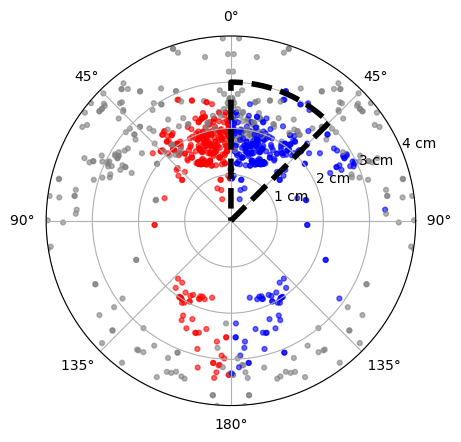

In [71]:
# Set start and finish frames
a, b = 200, -1

# Determine the colors of the exploration points by the method that detected them
colors1 = ['red' if label == 1 else 'gray' for label in manual_label[a:b]]
colorsBA1 = ['blue' if label == 1 else 'gray' for label in BA_label[a:b]]

fig = plt.figure()
ax = fig.add_subplot(projection='polar')

c = ax.scatter((angle1[a:b] + 90) / 180 * np.pi, dist1[a:b] / 20, c = colors1, s = 12, alpha = 0.6)
c = ax.scatter(-(angle1[a:b]-90) / 180 * np.pi, dist1[a:b] / 20, c = colorsBA1, s = 12, alpha = 0.6)

ang_plot = np.linspace(np.pi/4, np.pi / 2, 25).tolist()

c = ax.plot([0] + ang_plot + [0], [0] + [3] * 25 + [0], c = "k", linestyle = 'dashed', linewidth = 4)

plt.ylim([0, 4])
plt.yticks([1, 2, 3, 4], ["1 cm", "2 cm", "3 cm", "4 cm"])
plt.xticks(
    [0, 45 / 180 * np.pi, 90 / 180 * np.pi, 135 / 180 * np.pi, np.pi, 225 / 180 * np.pi, 270 / 180 * np.pi, 315 / 180 * np.pi],
    ["  90°", "45°", "0°", "45°", "90°  ", "135°    ", "180°", "    135°"]
)

plt.show()

We can see that all three methods seem to agree in the region considered for explorations by our custom algorithm, since most points there are also detected by our manual method and by the Machine Learning algorithm.

However, there are several points in the range of angles between $135$° and $180$° where both the manual method and the Machine Learning algorithm detect explorations; this range is not considered by our custom algorithm, which shows its limitations.

We now create an analogous plot for object 2.

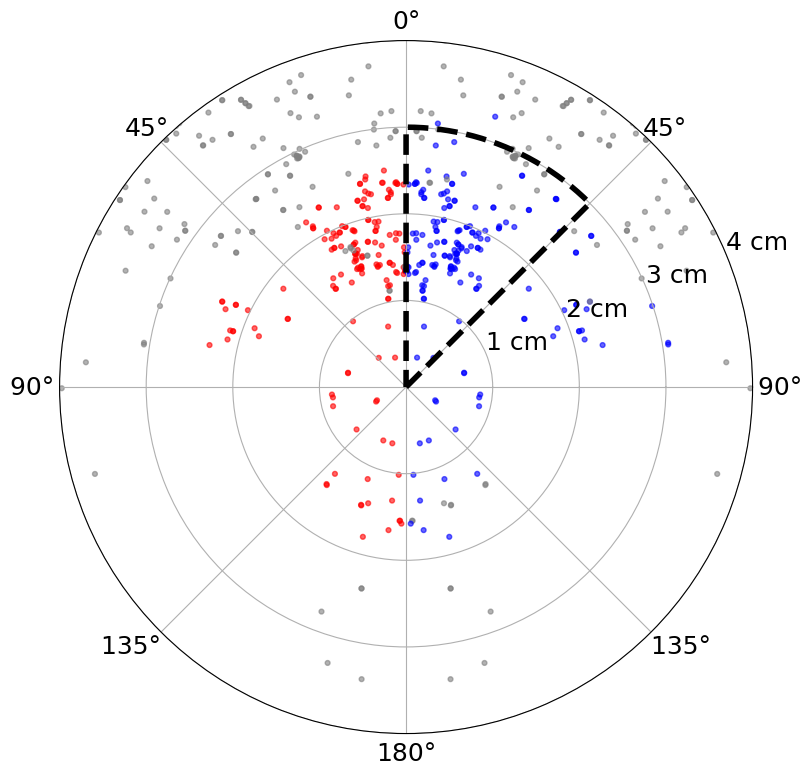

In [74]:
plt.rcParams['figure.figsize'] = [9,9]
plt.rcParams['font.size'] = 18

# Set start and finish frames
a, b = 200, -1

# Determine the colors of the exploration points by the method that detected them
colors2 = ['red' if label == -1 else 'gray' for label in manual_label[a:b]]
colorsBA2 = ['blue' if label == -1 else 'gray' for label in BA_label[a:b]]

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter((angle2[a:b] + 90) / 180 * np.pi, dist2[a:b] / 20, c = colors2, s = 12, alpha=0.6)
c = ax.scatter(-(angle2[a:b] - 90) / 180 * np.pi, dist2[a:b] / 20, c = colorsBA2, s = 12, alpha=0.6)

ang_plot = np.linspace(np.pi / 4, np.pi / 2, 25).tolist()

c = ax.plot([0] + ang_plot + [0], [0] + [3] * 25 + [0], c="k", linestyle='dashed', linewidth = 4)

plt.ylim([0,4])
plt.yticks([1,2,3,4],["1 cm","2 cm","3 cm","4 cm"])
plt.xticks(
    [0, 45/180*np.pi,90/180*np.pi,135/180*np.pi,np.pi,225/180*np.pi,270/180*np.pi,315/180*np.pi],
    ["  90°","45°", "0°","45°","90°  ", "135°    ","180°","    135°"]
)
plt.show()

Once again, all three methods seem to agree for points in the region considered by our custom algorithm. However, we find that several points outside that region are detected as explorations by both our manual method and the Machine Learning algorithm.

## Accuracy scores

EXPLICACIÓN DE LO QUE VAMOS A HACER

In [ ]:
suma_auto1_error = 0
suma_auto1_falso = 0
suma_auto1 = 0
suma_bosque1_error = 0
suma_bosque1_falso = 0
suma_bosque1 = 0
eventos = 0


for i in range(len(manual_label)):
    if manual_label[i] != 0 and auto_label[i] == 0:
        suma_auto1_error += 1
    if manual_label[i] == 0 and auto_label[i] != 0:
        suma_auto1_falso += 1
    if manual_label[i] != 0 and auto_label[i] != 0:
        suma_auto1 += 1
    if manual_label[i] != 0 and BA_label[i] == 0:
        suma_bosque1_error += 1        
    if manual_label[i] == 0 and BA_label[i] != 0:
        suma_bosque1_falso += 1
    if manual_label[i] != 0 and BA_label[i] != 0:
        suma_bosque1 += 1
    if manual_label[i] != 0:
        eventos += 1
    

print(eventos/len(manual_label))

print(suma_auto1/len(manual_label))
print(suma_bosque1/len(manual_label))

print(suma_auto1/eventos)
print(suma_bosque1/eventos)

print(eventos/len(manual_label))
print(suma_auto1_falso/eventos)
print(suma_bosque1_falso/eventos)

ALGÚN ANÁLISIS DE LO QUE DA